## The data

The data set is downloaded from the kaggle link mentioned below. There are 3,000 reviews included and 10 features recorded: 
- country: The country that the wine is from
- description: A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- designation: The vineyard within the winery where the grapes that made the wine are from
- points: The number of points WineEnthusiast rated the wine on a scale of 1-100
- price: The cost for a bottle of the wine
- province: The province or state that the wine is from
- region_1: The wine growing area in a province or state
- region_2: Sometimes there are more specific regions specified within a wine growing area
- variety: The type of grapes used to make the wine
- winery: The winery that made the wine

(Source: https://www.kaggle.com/zynicide/wine-reviews)

# Analysis tools - Text Clustering on Description

A cluster is a group of similar objects. Clustering systematically assigns objects into groups by similarity
"Similarity" is usually defined as a distance between two objects

Word2vec word embedding is used on the description column to extract features for modeling. The gensim package (https://radimrehurek.com/gensim/index.html) was built "to realize unsupervised semantic modelling from plain text", and its implementation of word2vec is highly used. Word2vec uses neural networks to learn word embeddings from a corpus

Genism word2vec requires a "list of lists" input for training. This means that every document is contained in a list, every list contains lists of tokens of that document.



In [1]:
import gensim 
from gensim.models import Word2Vec

import nltk
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import numpy as np
import pandas as pd
import re

from sklearn import cluster
from sklearn import metrics

# Preprocessing
The raw text 'description' input will be preprocessed by 
- tokenizing the wine descriptions
- removing special characters
- stemming words

# Training data

In [23]:
data = pd.read_csv('winemag-data_first150k.csv')
data = data.sample(n=3000, replace=False, random_state=20)
print('Shape of dataframe :', data.shape)
data.head()

Shape of dataframe : (3000, 11)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
49827,49827,US,"A superb white wine, and at this price, buy it...",NaN,90,10.0,California,California,California Other,White Blend,Kitchen Sink
80693,80693,US,"This shows deep, classic flavors of sweet blac...",Estate,89,60.0,California,Oakville,Napa,Cabernet Sauvignon,Ghost Block
135476,135476,US,Rugged tannins are front and center in this yo...,NaN,92,22.0,California,Mendocino County,Mendocino/Lake Counties,Syrah,Eaglepoint Ranch
139565,139565,US,"Here's an elegant, full-bodied Syrah that tast...",NaN,90,20.0,California,Mendocino,Mendocino/Lake Counties,Syrah,Jepson
57294,57294,Italy,"Made with organically farmed grapes, this pret...",Ombrone,93,68.0,Tuscany,Sant'Antimo,NaN,Red Blend,Cupano


In [4]:
ps = PorterStemmer()
descriptions = map(lambda x: [ps.stem(word) for word in word_tokenize(x) if word.isalpha()], data['description'])
descriptions = list(descriptions)

In [20]:
# below is a sample of one of the reviews that shows how the words are tokenized and then stemmed.
descriptions[0]

['A',
 'superb',
 'white',
 'wine',
 'and',
 'at',
 'thi',
 'price',
 'buy',
 'it',
 'by',
 'the',
 'case',
 'made',
 'from',
 'chardonnay',
 'chenin',
 'blanc',
 'and',
 'gewürztramin',
 'it',
 'streamlin',
 'and',
 'dri',
 'with',
 'raci',
 'acid',
 'frame',
 'citru',
 'lyche',
 'pear',
 'honeysuckl',
 'miner',
 'and',
 'spice',
 'flavor',
 'product',
 'wa',
 'case',
 'and',
 'the',
 'alcohol',
 'is',
 'a',
 'low']

### Model parameters
- min_count: min_count (int, optional) – Ignores all words with total frequency lower than this.
- sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW. Skip gram is 

In [5]:
model = Word2Vec(descriptions, min_count=2, sg=1) #This step takes time!

In [6]:
print(len(list(model.wv.vocab)))

2919


### A word embedding

In [25]:
#A sample of word embedding for 'oak'
model.wv['oak']

array([-0.04518435, -0.08453028, -0.29645073, -0.14436889,  0.14747839,
       -0.30798894,  0.159723  , -0.5347444 ,  0.1911492 ,  0.19370575,
        0.23511758, -0.15929377, -0.06444754,  0.21454574,  0.0509088 ,
        0.11400319,  0.07493906, -0.17412385,  0.187489  , -0.36534023,
       -0.21742429,  0.23028195, -0.05112554, -0.1944879 ,  0.03674484,
        0.0844943 ,  0.01203191, -0.00384511,  0.19979572, -0.17892566,
        0.18430373,  0.27850237, -0.61278456, -0.23063873, -0.22631891,
       -0.28461784,  0.05377599, -0.27603424,  0.27473384,  0.30769476,
        0.1154244 , -0.12451614, -0.19157714,  0.30945033,  0.27022615,
        0.09347527,  0.34397265,  0.17393087, -0.1735978 ,  0.36517358,
        0.21470034, -0.06330494, -0.15039049,  0.4113133 , -0.01263885,
        0.06461133, -0.06636512,  0.1582422 , -0.08866747,  0.33394152,
        0.38969564, -0.1384458 , -0.02731778,  0.21085115, -0.063711  ,
       -0.20338076, -0.03771929, -0.295212  , -0.09767574, -0.13

### What words are most similar, given a word of interest?

In [8]:
pd.DataFrame(model.wv.similar_by_word('sweet'))

,0,1
0,coat,0.948680
1,oaki,0.938400
2,toasti,0.936141
3,plump,0.934455
4,syrupi,0.933761
5,sticki,0.930593
6,chunki,0.925008
7,sugari,0.924049
8,subtl,0.922424
9,flood,0.922081


In [9]:
pd.DataFrame(model.wv.similar_by_word('aroma'))

,0,1
0,tone,0.954757
1,scent,0.945039
2,rose,0.932505
3,whiff,0.928548
4,petal,0.928290
5,crush,0.928081
6,powder,0.920706
7,mix,0.916600
8,forest,0.915032
9,exot,0.915001


In [10]:
pd.DataFrame(model.wv.similar_by_word('smooth'))

,0,1
0,velveti,0.981297
1,suppl,0.974114
2,silki,0.967789
3,chewi,0.948915
4,round,0.944487
5,bodi,0.942376
6,solid,0.935664
7,mouthfeel,0.933124
8,gentl,0.932778
9,tight,0.931709


### How similar are two words?

In [11]:
print(model.wv.similarity('smooth', 'aroma'))

print(model.wv.similarity('sweet', 'smoke'))

print(model.wv.similarity('valley', 'fruit'))

0.52106184
0.70939577
0.37013364


# Clustering
In order to cluster at the sentence/description level, we need to summarize the embeddings. For each description, the word embedding of each word is summed and then divided by the number of words in the description.

In [12]:
def desc_vectorizer(desc, model):
    desc_vec =[]
    numw = 0
    for w in desc:
        try:
            if numw == 0:
                desc_vec = model.wv[w]
            else:
                desc_vec = np.add(desc_vec, model.wv[w])
            numw+=1
        except:
            pass
     
    return np.asarray(desc_vec) / numw

In [13]:
X = []
for d in descriptions:
    X.append(desc_vectorizer(d, model))

In [14]:
X[0]

array([-9.45121422e-02,  6.61141351e-02, -2.50798166e-01, -1.27098843e-01,
        1.75507128e-01, -1.33098766e-01,  1.02893896e-01, -1.94384024e-01,
        2.02217296e-01,  1.52267125e-02,  1.58057466e-01, -2.87498850e-02,
       -9.27879363e-02,  1.61899596e-01,  2.51180697e-02,  9.70624909e-02,
        1.22372381e-01,  3.16031091e-02,  5.26220314e-02, -2.48613521e-01,
       -1.24763288e-01,  2.01490611e-01, -2.28308782e-01, -1.79205760e-01,
        1.33975729e-01,  8.81755201e-04,  1.13277614e-01,  5.19758835e-03,
        2.72234846e-02, -4.75335360e-01,  2.18798127e-02,  1.23495907e-01,
       -3.41549307e-01, -3.18522081e-02,  1.80160757e-02, -2.55114585e-02,
       -2.26016685e-01, -1.77996933e-01,  5.04742451e-02,  9.84428599e-02,
        9.15479213e-02, -1.18639752e-01,  9.80838910e-02,  1.80582747e-01,
       -4.90120091e-02,  1.97991863e-01,  2.25486353e-01, -2.60756500e-02,
        3.66211087e-02,  1.01153120e-01,  1.09977350e-01, -6.94530904e-02,
       -2.24691376e-01,  

# K-means clustering

### 2 clusters

In [15]:
NUM_CLUSTERS = 2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print(assigned_clusters[:3]) 

[0, 0, 0]


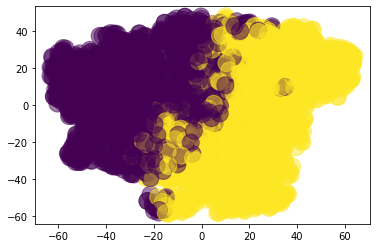

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsnemodel = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y = tsnemodel.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
plt.show()

### 4 clusters

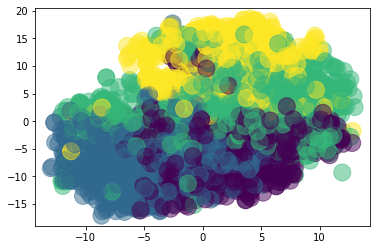

In [27]:
NUM_CLUSTERS = 3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
tsnemodel = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)

Y = tsnemodel.fit_transform(X)


plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
plt.show()